In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch
import h5py

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [3, 1]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Settings

In [28]:
nbatch = 2000
N = 3
M = 4
num_dim = 1
num_discrete_values = 16
num_qubits = int(N**2 * np.log2(M))

file_name = "QG_train_normalized_N3_M4_bilinear"

reg = 0.000001

## Data

In [29]:
f = h5py.File(file_name,"r")

In [30]:
x_train = f.get('X')
y_train = f.get('y')

(-0.5, 2.5, 2.5, -0.5)

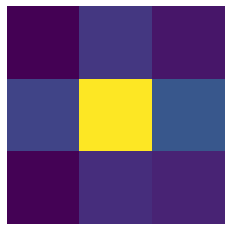

In [31]:
plt.imshow(np.mean(x_train[y_train[:]==1],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

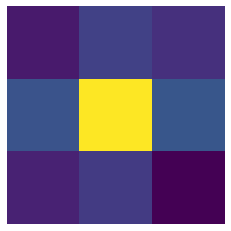

In [32]:
plt.imshow(np.mean(x_train[y_train[:]==0],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

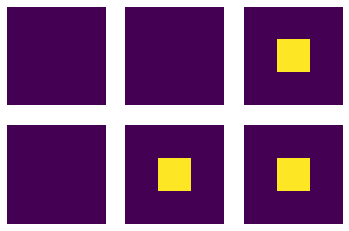

In [33]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,6,size=(6,))
ax[0,0].imshow(x_train[nums[0]])
ax[0,0].axis('off')
ax[0,1].imshow(x_train[nums[1]])
ax[0,1].axis('off')
ax[0,2].imshow(x_train[nums[2]])
ax[0,2].axis('off')
ax[1,0].imshow(x_train[nums[3]])
ax[1,0].axis('off')
ax[1,1].imshow(x_train[nums[4]])
ax[1,1].axis('off')
ax[1,2].imshow(x_train[nums[5]])
ax[1,2].axis('off')

In [34]:
data = x_train[y_train[:]==1]

In [35]:
f.close()

In [36]:
data.shape

(3008, 3, 3)

## Utillity functions

In [37]:
def int_to_bin_list(num,bits):
    return [(num>>k)&1 for k in range(0,bits)][::-1]

In [38]:
def convert_dim_to_integer(arr,dim):
    # Calculate the number of possible values 
    num_values = 2 ** arr.shape[dim]
    arr = torch.flip(arr,(1,))
    # Sum along the last dimension to convert it to integers
    integer_array = np.sum(arr * (2 ** np.arange(arr.shape[dim])), axis=-1)

    return torch.tensor(integer_array)

In [39]:
def normalize_image(img):
    return img / 3

In [40]:
def basis_array_to_img(basis_array):
    basis_array = basis_array.reshape(3,3,2)
    return normalize_image(convert_dim_to_integer(basis_array,2))

In [41]:
def batch_basis_array_to_img(batch_basis_array):
    batch_basis_array = batch_basis_array.reshape(batch_basis_array.shape[0],3,3,2)
    return normalize_image(convert_dim_to_integer(batch_basis_array,3))

In [42]:
def tensor_to_int(tensor):
    tensor = tensor.long()
    
    # Calculate the number of columns in the tensor
    num_columns = tensor.size(1)
    
    # Create a weight tensor for binary to integer conversion
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    
    # Calculate the integer values for each row
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [43]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(n, samples_tuple):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=6.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)
    #ax3.grid()

    # Relative Entropy
    ax2.plot(entropy_values)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    #ax2.grid()
    
    paramsg = generator.weights
    generated_probabilities = circuit(1,paramsg).detach()
    ax1.plot(generated_probabilities, label="generated")
    ax1.plot(prob_data,label="real")
    ax1.legend(loc="upper right", fontsize=18)
    ax1.set_xlabel("$i$", fontsize=18)
    ax1.set_ylabel("$P_i$", fontsize=18)
    #ax3.grid()
    #plt.savefig(f"imgs/plt-{n}.png")
    
    ax4.plot(discriminator(torch.tensor(list(range(16))).reshape(16,1).float()).detach())
    ax4.set_xlabel("$i$", fontsize=18)
    ax4.set_ylabel("$D(i)$", fontsize=18)
    
    for samples in samples_tuple:
        values, counts = np.unique(samples, return_counts=True)
        if (values == np.arange(0,16)).all(): ax5.plot(counts)
    ax5.set_xlabel("i")
    ax5.set_ylabel("sample distribution")
        

    plt.show()

In [44]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

# Model

## Generator circuits

In [45]:
dev = qml.device("default.qubit.torch", wires=18)

@qml.qnode(dev, interface="torch", diff_method="backprop", cachesize=1000000)
def circuit(inputs, weights):
    for wire in range(18): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(18)))
    return qml.probs()

In [46]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.sample()

## Hybrid model building

In [47]:
n_layers=1
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [48]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [49]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        print(input.shape)
        x = self.flatten(input)
        print(x.shape)
        x = self.linear_input(x)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [50]:
generator = qlayer
discriminator = Discriminator(N**2)

# Training

In [51]:
from torch.optim import Adam

lr = 0.001  # learning rate
#b1 = 0.7  # first momentum parameter
b1 = 0.6  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

decayRate = 0.9999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)

In [52]:
def adversarial_loss(inputs, target, w):
    bce_loss = target * torch.log(inputs) + (1 - target) * torch.log(1 - inputs)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [61]:
import time
from scipy.stats import multivariate_normal, entropy

torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)

n_epochs = 2000

num_qnn_outputs = num_discrete_values**num_dim

data = torch.tensor(data, requires_grad=False)

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(nbatch, dtype=torch.float)
    fake = torch.zeros(nbatch, dtype=torch.float)

    #samples = tensor_to_int(circuit_sample(1, list(generator.parameters())[0].detach()))
    #samples = torch.tensor(np.random.randint(0,16, size=(nbatch,)), dtype=torch.float).reshape(nbatch,1)
    samples = torch.tensor(np.random.randint(0,2,size=(nbatch,18)), dtype=torch.float)
    samples_idx = convert_dim_to_integer(samples,1)
    samples_img = batch_basis_array_to_img(samples)
    
    #samples = samples.float().reshape(-1,1)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
 
        # discriminator values
        print("Evalutaing discriminator at samples")
        disc_value = discriminator(samples_img.float())
        print("done evaluating discriminator")
    
        # gen dist
        print("Evaluating Generator")
        gen_dist = generator(torch.tensor([]))
        print("done Evaluating Generator")
        
        # Train generator
        generator_optimizer.zero_grad()
        print("Evaluating Generator loss")
        generator_loss = adversarial_loss(disc_value.detach().reshape(-1), valid, gen_dist[samples_idx.long().reshape(-1)])
        print("done Evaluating Generator loss")
        
        # store for plotting
        generator_loss_values.append(generator_loss.detach().item())

        print("Generator loss backwards")
        generator_loss.backward(retain_graph=True)
        print("done Generator loss backwards ")
        print("Generator step ")
        generator_optimizer.step()
        print("done Generator step ")

        # Train Discriminator
        discriminator_optimizer.zero_grad()
     
        print("discriminator from data")
        real_disc_vals = discriminator(Xbatch.float())
        print("done discriminator from data")
    
        print("discriminator loss")
        real_loss = adversarial_loss(real_disc_vals.reshape(-1), valid, torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        fake_loss = adversarial_loss(disc_value.reshape(-1), fake, gen_dist.detach()[samples_idx.long().reshape(-1)])
        discriminator_loss = (real_loss + fake_loss) / 2
        print("done discriminator loss ")
        
        # Store for plotting
        discriminator_loss_values.append(discriminator_loss.detach().item())
    
        print("discriminator step")
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        entropy_value = entropy(gen_dist.detach().squeeze().numpy()+reg, prob_data+reg)
        entropy_values.append(entropy_value)

        my_lr_scheduler.step()

        plot_training_progress(epoch, (samples,))
    break
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

/tmp/ipykernel_94114/1659427866.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, requires_grad=False)


Evalutaing discriminator at samples
torch.Size([2000, 3, 3])
torch.Size([2000, 9])
done evaluating discriminator
Evaluating Generator
done Evaluating Generator
Evaluating Generator loss
done Evaluating Generator loss
Generator loss backwards
done Generator loss backwards 
Generator step 
done Generator step 
discriminator from data
torch.Size([2000, 3, 3])
torch.Size([2000, 9])
done discriminator from data
discriminator loss
done discriminator loss 
discriminator step


NameError: name 'prob_data' is not defined

In [57]:
disc_value.shape

torch.Size([2000, 1])

In [60]:
gen_dist.detach()[samples_idx.long().reshape(-1)].shape

torch.Size([2000])

In [ ]:
discriminator(Xbatch)

In [ ]:
paramsg = generator.weights
generated_probabilities = circuit(1,paramsg).detach()

In [ ]:
plt.plot(generated_probabilities)